In [1]:
import torch

from matplotlib import pyplot as plt

from eot_benchmark.gaussian_mixture_benchmark import GaussianMixture, ConditionalPlan

from sklearn.decomposition import PCA
import numpy as np

from collections import defaultdict

KeyboardInterrupt: 

In [ ]:
def initialize_centers(dim, num, dist, std, standardized=False):
    centers = np.zeros((num, dim), dtype=np.float32)
    for d in range(dim):
        idx = np.random.choice(list(range(num)), num, replace=False)
        centers[:, d] += dist * idx
    centers -= dist * (num - 1) / 2

    if standardized:
        mult = np.sqrt((centers ** 2).sum(axis=1).mean() + dim * std ** 2) / np.sqrt(dim)
        centers /= mult
    
    return centers

In [10]:
def initialize_gaussians(dim, n_comp, dist, std, standardized=False):

    probs = torch.rand(n_comp)
    probs = probs/probs.sum()
    
    centers = initialize_centers(dim=dim, num=n_comp, dist=dist, std=std, standardized=standardized)
    mus = torch.tensor(centers)
    sigmas_sqrt = torch.stack([torch.diag(std*torch.ones(dim))]*n_comp, dim=0)
    sigmas = torch.stack([sigma_sqrt@sigma_sqrt.T for sigma_sqrt in sigmas_sqrt], dim=0)
    
    return probs, mus, sigmas

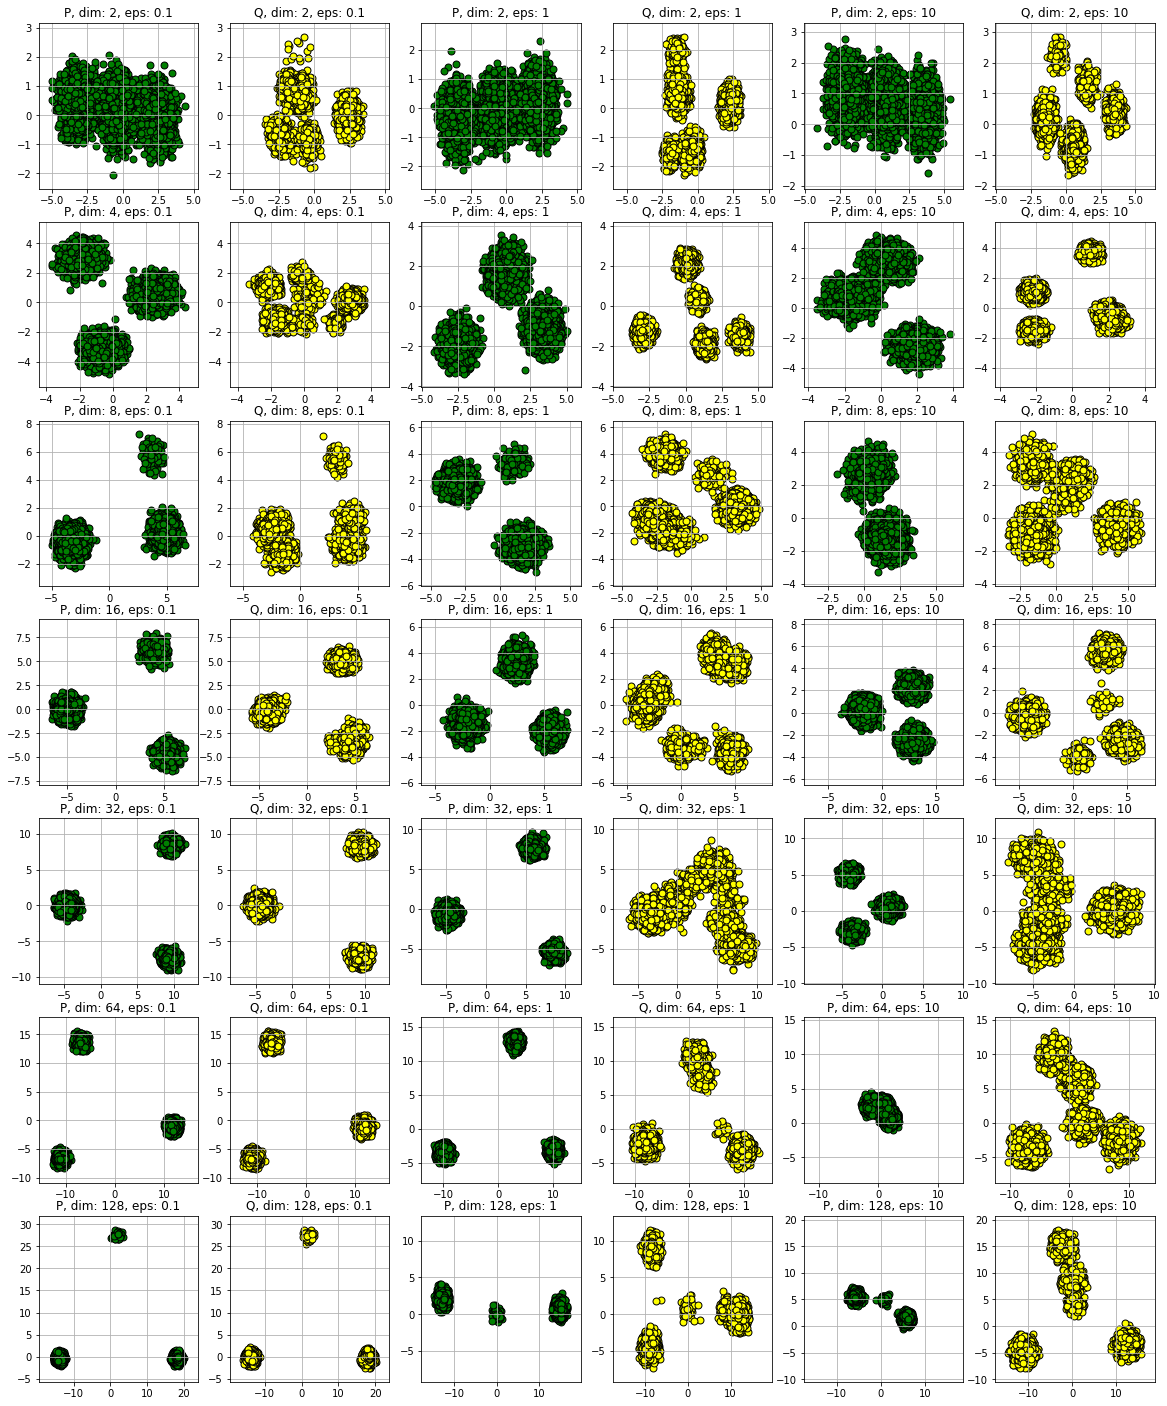

In [13]:
dims = [2, 4, 8, 16, 32, 64, 128]
eps_array = [0.1, 1, 10]

params = {
    0.1 : {
        2: 0.5,
        4: 0.5,
        8: 1,
        16: 1,
        32: 4,
        64: 8,
        128: 8
    },
    1 : {
        2: 0.5,
        4: 0.5,
        8: 1,
        16: 1,
        32: 2,
        64: 2,
        128: 2
    },
    10 : {
        2: 0.5,
        4: 0.5,
        8: 1,
        16: 1,
        32: 2,
        64: 2,
        128: 2
    }
}

fig, axes = plt.subplots(len(dims), len(eps_array)*2, figsize=(20, 25))

benchmark_data_gm = defaultdict(tuple)
benchmark_conditional_plan = defaultdict(list)

for i, dim in enumerate(dims):
    probs, mus, sigmas = initialize_gaussians(dim=dim, n_comp=3, dist=2, std=0.5, standardized=False)
    gm = GaussianMixture(probs=probs, mus=mus, sigmas=sigmas)
    benchmark_data_gm[dim] = (probs, mus, sigmas)
    
    for j, eps in enumerate(eps_array):
#         print(0.5*params[eps][dim])
        probs, mus, sigmas = initialize_gaussians(dim=dim, n_comp=5,
                                                  dist=1, std=0.5*params[eps][dim], standardized=False)
        conditional_plan = ConditionalPlan(probs, mus, sigmas, eps=eps)
        benchmark_conditional_plan[dim].append((probs, mus, sigmas))

        samples = gm.sample(10000)
        cond_samples = conditional_plan.sample(samples)

#         pca = PCA(n_components=2)
#         samples_pca = pca.fit_transform(samples)

        pca = PCA(n_components=2)
        cond_samples_pca = pca.fit_transform(cond_samples)
        samples_pca = pca.transform(samples)

        axes[i, 2*j].scatter(
            samples_pca[:, 0], samples_pca[:, 1],
            c="green", s=48, edgecolors="black", label="Fitted distribution"
        )
        
        axes[i, 2*j + 1].scatter(
            cond_samples_pca[:, 0], cond_samples_pca[:, 1],
            c="yellow", s=48, edgecolors="black", label="Fitted distribution"
        )

        mins = np.concatenate((samples_pca, cond_samples_pca), axis=0).min(axis=0)
        maxs = np.concatenate((samples_pca, cond_samples_pca), axis=0).max(axis=0)
        
        delta = maxs - mins
        
        maxs += delta*0.1
        mins -= delta*0.1
        
        axes[i, 2*j].grid()
        axes[i, 2*j + 1].grid()
        
        axes[i, 2*j].set_xlim(mins[0], maxs[0])
        axes[i, 2*j].set_ylim(mins[1], maxs[1])
        
        axes[i, 2*j+1].set_xlim(mins[0], maxs[0])
        axes[i, 2*j+1].set_ylim(mins[1], maxs[1])
        
        axes[i, 2*j].set_title(f"P, dim: {dim}, eps: {eps}")
        axes[i, 2*j+1].set_title(f"Q, dim: {dim}, eps: {eps}")
#         axes[i, j].set_xlim(-5, 5)
#         axes[i, j].set_ylim(-5, 5)
        
plt.show()

In [14]:
benchmark_data_gm

defaultdict(tuple,
            {2: (tensor([0.3887, 0.2625, 0.3488]), tensor([[ 0.,  0.],
                      [ 2.,  2.],
                      [-2., -2.]]), tensor([[[0.2500, 0.0000],
                       [0.0000, 0.2500]],
              
                      [[0.2500, 0.0000],
                       [0.0000, 0.2500]],
              
                      [[0.2500, 0.0000],
                       [0.0000, 0.2500]]])),
             4: (tensor([0.3924, 0.3231, 0.2845]),
              tensor([[ 0., -2.,  0., -2.],
                      [ 2.,  0.,  2.,  2.],
                      [-2.,  2., -2.,  0.]]),
              tensor([[[0.2500, 0.0000, 0.0000, 0.0000],
                       [0.0000, 0.2500, 0.0000, 0.0000],
                       [0.0000, 0.0000, 0.2500, 0.0000],
                       [0.0000, 0.0000, 0.0000, 0.2500]],
              
                      [[0.2500, 0.0000, 0.0000, 0.0000],
                       [0.0000, 0.2500, 0.0000, 0.0000],
                       [0.000

In [19]:
for i, dim in enumerate(dims):
    probs, mus, sigmas = benchmark_data_gm[dim]
    
    torch.save(probs, f"gaussian_mixture_benchmark_data/input_probs_dim_{dim}.torch")
    torch.save(mus, f"gaussian_mixture_benchmark_data/input_mus_dim_{dim}.torch")
    torch.save(sigmas, f"gaussian_mixture_benchmark_data/input_sigmas_dim_{dim}.torch")
    
    for j, eps in enumerate(eps_array):
        probs, mus, sigmas = benchmark_conditional_plan[dim][j]
        
        torch.save(probs, f"gaussian_mixture_benchmark_data/potential_probs_dim_{dim}_eps_{eps}.torch")
        torch.save(mus, f"gaussian_mixture_benchmark_data/potential_mus_dim_{dim}_eps_{eps}.torch")
        torch.save(sigmas, f"gaussian_mixture_benchmark_data/potential_sigmas_dim_{dim}_eps_{eps}.torch")

In [2]:
from eot_benchmark.gaussian_mixture_benchmark import download_gaussian_mixture_benchmark_files

In [3]:
download_gaussian_mixture_benchmark_files()

Downloading...
From: https://drive.google.com/uc?id=1HNXbrkozARbz4r8fdFbjvPw8R74n1oiY
To: /root/eot_benchmark_data/gaussian_mixture_benchmark_data.zip
100%|██████████| 63.0k/63.0k [00:00<00:00, 1.63MB/s]


In [171]:
samples = gm.sample(10000)
cond_samples = conditional_plan.sample(samples)

pca = PCA(n_components=2)
samples_pca = pca.fit_transform(samples)

pca = PCA(n_components=2)
cond_samples_pca = pca.fit_transform(cond_samples)

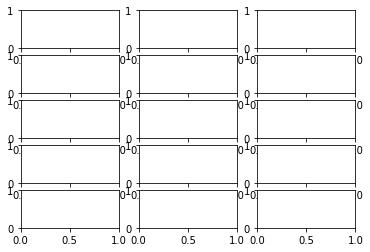

In [ ]:
for

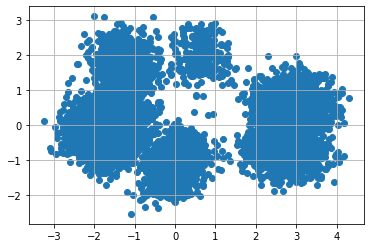

In [173]:
plt.scatter(cond_samples_pca[:, 0], cond_samples_pca[:, 1])
plt.grid()

In [111]:
gm = GaussianMixture(probs=probs, mus=mus, sigmas=sigmas)

In [112]:
samples = gm.sample(10000)

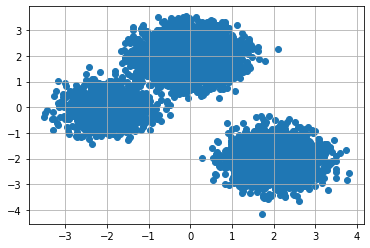

In [113]:
plt.scatter(samples[:, 0], samples[:, 1])
plt.grid()

In [118]:
dim=2
num=10
dist=1
std=0.4
standardized=False 
estimate_size=2**14
batch_size=1024
device='cuda'


centers = np.zeros((num, dim), dtype=np.float32)
for d in range(dim):
    idx = np.random.choice(list(range(num)), num, replace=False)
    centers[:, d] += dist * idx
centers -= dist * (num - 1) / 2

if standardized:
    mult = np.sqrt((centers ** 2).sum(axis=1).mean() + dim * std ** 2) / np.sqrt(dim)
    centers /= mult

In [126]:
n_comp = 10
dim = 2

probs = torch.ones(n_comp)
probs = probs/probs.sum()

# mus = 1*torch.randn(n_comp, dim)
# sigmas_sqrt = torch.randn(n_comp, dim, dim)
# mus = torch.stack([torch.tensor([-10., -10]), torch.tensor([-10., 15]),
#                    torch.tensor([10., 15]), torch.tensor([10., -10]),
#                   torch.tensor([0., 20])], dim=0)

# radius = torch.kthvalue(torch.cdist(mus, mus).reshape(-1), n_comp_P+1)[0]
# centers = []
# for i in range(n_comp):
#     v = torch.randn(dim)
#     v = radius*(v/torch.norm(v))
#     ind = np.random.randint(0, n_comp_P)
#     centers.append(v + mus[ind])

# mus = torch.stack(centers, dim=0)
mus = torch.tensor(centers)

sigmas_sqrt = torch.stack([torch.diag(torch.ones(dim))]*n_comp, dim=0)
sigmas = 0.1*torch.stack([sigma_sqrt@sigma_sqrt.T for sigma_sqrt in sigmas_sqrt], dim=0)
# sigmas = torch.stack([sigma_sqrt@sigma_sqrt.T for sigma_sqrt in sigmas_sqrt], dim=0)

In [151]:
conditional_plan = ConditionalPlan(probs, mus, sigmas, eps=0.1)

In [152]:
cond_samples = conditional_plan.sample(samples)

In [153]:
pca = PCA(n_components=2)
pca.fit(cond_samples)
cond_samples_pca = pca.transform(cond_samples)

# plt.scatter(samples_pca[:, 0], samples_pca[:, 1])
plt.scatter(cond_samples_pca[:, 0], cond_samples_pca[:, 1])
plt.grid()